## Kaggle – DataTops®
Luismi ha decidido cambiar de aires y, por eso, ha comprado una tienda de portátiles. Sin embargo, su única especialidad es Data Science, por lo que ha decidido crear un modelo de ML para establecer los mejores precios.

¿Podrías ayudar a Luismi a mejorar ese modelo?

## Métrica: 
Error de raíz cuadrada media (RMSE) es la desviación estándar de los valores residuales (errores de predicción). Los valores residuales son una medida de la distancia de los puntos de datos de la línea de regresión; RMSE es una medida de cuál es el nivel de dispersión de estos valores residuales. En otras palabras, le indica el nivel de concentración de los datos en la línea de mejor ajuste.


$$ RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}}$$


## Librerías

In [7]:
import warnings
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRFRegressor
import urllib
from PIL import Image

warnings.filterwarnings ( 'ignore' )
from sklearn.pipeline import Pipeline
pd.set_option ( "display.max_columns" , None )
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge 
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor 
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, Normalizer, StandardScaler , OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

## Datos

In [9]:
# Para que funcione necesitas bajarte los archivos de datos de Kaggle 
df_train = pd.read_csv("./data/train.csv", index_col = 0)
df_train.index.name = None
df_train

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_in_euros
755,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.86kg,539.00
618,Dell,Inspiron 7559,Gaming,15.6,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,16GB,1TB HDD,Nvidia GeForce GTX 960<U+039C>,Windows 10,2.59kg,879.01
909,HP,ProBook 450,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,Nvidia GeForce 930MX,Windows 10,2.04kg,900.00
2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
286,Dell,Inspiron 3567,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,AMD Radeon R5 M430,Linux,2.25kg,428.00
...,...,...,...,...,...,...,...,...,...,...,...,...
28,Dell,Inspiron 5570,Notebook,15.6,Full HD 1920x1080,Intel Core i5 8250U 1.6GHz,8GB,256GB SSD,AMD Radeon 530,Windows 10,2.2kg,800.00
1160,HP,Spectre Pro,2 in 1 Convertible,13.3,Full HD / Touchscreen 1920x1080,Intel Core i5 6300U 2.4GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.48kg,1629.00
78,Lenovo,IdeaPad 320-15IKBN,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,2TB HDD,Intel HD Graphics 620,No OS,2.2kg,519.00
23,HP,255 G6,Notebook,15.6,1366x768,AMD E-Series E2-9000e 1.5GHz,4GB,500GB HDD,AMD Radeon R2,No OS,1.86kg,258.00


In [10]:
df_test = pd.read_csv("./data/test.csv", index_col = 0)
df_test.index.name = None
df_test

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
209,Lenovo,Legion Y520-15IKBN,Gaming,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,512GB SSD,Nvidia GeForce GTX 1060,No OS,2.4kg
1281,Acer,Aspire ES1-531,Notebook,15.6,1366x768,Intel Celeron Dual Core N3060 1.6GHz,4GB,500GB HDD,Intel HD Graphics 400,Linux,2.4kg
1168,Lenovo,V110-15ISK (i3-6006U/4GB/1TB/No,Notebook,15.6,1366x768,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,Intel HD Graphics 520,No OS,1.9kg
1231,Dell,Inspiron 7579,2 in 1 Convertible,15.6,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,2.191kg
1020,HP,ProBook 640,Notebook,14.0,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,4GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.95kg
...,...,...,...,...,...,...,...,...,...,...,...
820,MSI,GE72MVR 7RG,Gaming,17.3,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,512GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows 10,2.9kg
948,Toshiba,Tecra Z40-C-12X,Notebook,14.0,IPS Panel Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows 10,1.47kg
483,Dell,Precision M5520,Workstation,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,8GB,256GB SSD,Nvidia Quadro M1200,Windows 10,1.78kg
1017,HP,Probook 440,Notebook,14.0,1366x768,Intel Core i5 7200U 2.5GHz,4GB,500GB HDD,Intel HD Graphics 620,Windows 10,1.64kg


## Exploración de los datos

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 912 entries, 755 to 229
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           912 non-null    object 
 1   Product           912 non-null    object 
 2   TypeName          912 non-null    object 
 3   Inches            912 non-null    float64
 4   ScreenResolution  912 non-null    object 
 5   Cpu               912 non-null    object 
 6   Ram               912 non-null    object 
 7   Memory            912 non-null    object 
 8   Gpu               912 non-null    object 
 9   OpSys             912 non-null    object 
 10  Weight            912 non-null    object 
 11  Price_in_euros    912 non-null    float64
dtypes: float64(2), object(10)
memory usage: 92.6+ KB


## Analisis estadistico

In [14]:
df_train.describe()

,Inches,Price_in_euros
count,912.000000,912.000000
mean,14.981579,1111.724090
std,1.436719,687.959172
min,10.100000,174.000000
25%,14.000000,589.000000
50%,15.600000,978.000000
75%,15.600000,1483.942500
max,18.400000,6099.000000


In [15]:
df_train.describe(exclude = np.number)

,Company,Product,TypeName,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
count,912,912,912,912,912,912,912,912,912,912
unique,19,480,6,36,107,9,37,93,9,165
top,Lenovo,XPS 13,Notebook,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,2.2kg
freq,202,23,509,349,124,434,282,185,741,91


-----------------------------------------------------------------------------------------------------------------

## Analisis exploratorio

In [18]:
df_train[ 'TouchScreen' ] = df_train.ScreenResolution.apply ( lambda x : 1 if 'Touchscreen' in x else 0 )
df_train[ 'HD_4K' ] = df_train.ScreenResolution.apply ( lambda x : 1 if '4K' in x or 'HD' in x or 'HD+' in x else 0 )
df_train[ 'CPU_Types' ] = df_train.Cpu.apply ( lambda x : 'Samsung' if 'Samsung' in x else ( 'Intel' if 'Intel' in x else ( 'AMD' if 'AMD' in x else 'Intel' ) ) )
df_train[ 'Memory_Types' ] = df_train.Memory.apply ( lambda x : 'Flash Storage' if 'Flash Storage' in x else ( 'HDD' if 'HDD' in x else ( 'SSD' ) ) )
df_train[ 'GPU_Types' ] = df_train.Gpu.apply ( lambda x : 'AMD' if 'AMD' in x else ( 'Nvidia' if 'Nvidia' in x else ( 'Intel' ) ) )
df_train[ 'CPU_Frequency' ] = df_train.Cpu.str.extract (  r'(\d+GHz)' , expand = True )[0].str.replace ( 'GHz' , '' ).astype ( 'int64' )

In [19]:
df_test[ 'TouchScreen' ] = df_train.ScreenResolution.apply ( lambda x : 1 if 'Touchscreen' in x else 0 )
df_test[ 'HD_4K' ] = df_train.ScreenResolution.apply ( lambda x : 1 if '4K' in x or 'HD' in x or 'HD+' in x else 0 )
df_test[ 'CPU_Types' ] = df_train.Cpu.apply ( lambda x : 'Samsung' if 'Samsung' in x else ( 'Intel' if 'Intel' in x else ( 'AMD' if 'AMD' in x else 'Intel' ) ) )
df_test[ 'Memory_Types' ] = df_train.Memory.apply ( lambda x : 'Flash Storage' if 'Flash Storage' in x else ( 'HDD' if 'HDD' in x else ( 'SSD' ) ) )
df_test[ 'GPU_Types' ] = df_train.Gpu.apply ( lambda x : 'AMD' if 'AMD' in x else ( 'Nvidia' if 'Nvidia' in x else ( 'Intel' ) ) )
df_test[ 'CPU_Frequency' ] = df_train.Cpu.str.extract (  r'(\d+GHz)' , expand = True )[0].str.replace ( 'GHz' , '' ).astype ( 'int64' )

In [20]:
#  reemplazar los NaN con el valor más frecuente en df_train:
for col in ["TouchScreen", "HD_4K", "CPU_Types", "Memory_Types", "GPU_Types", "CPU_Frequency"]:
    df_test[col].fillna(df_train[col].mode()[0], inplace=True)


## Visualizacion de Datos

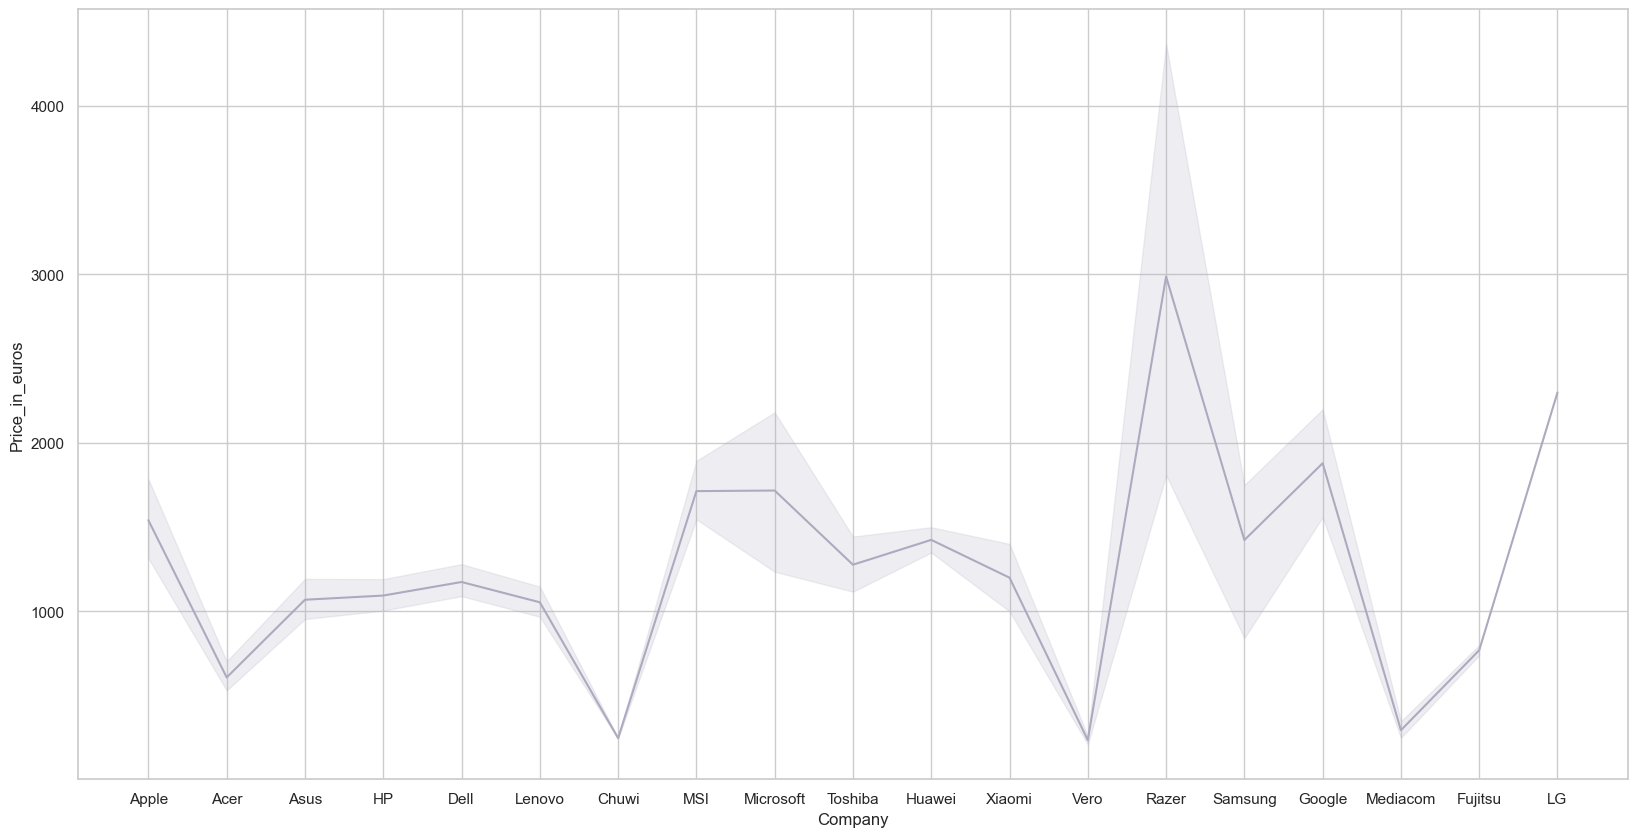

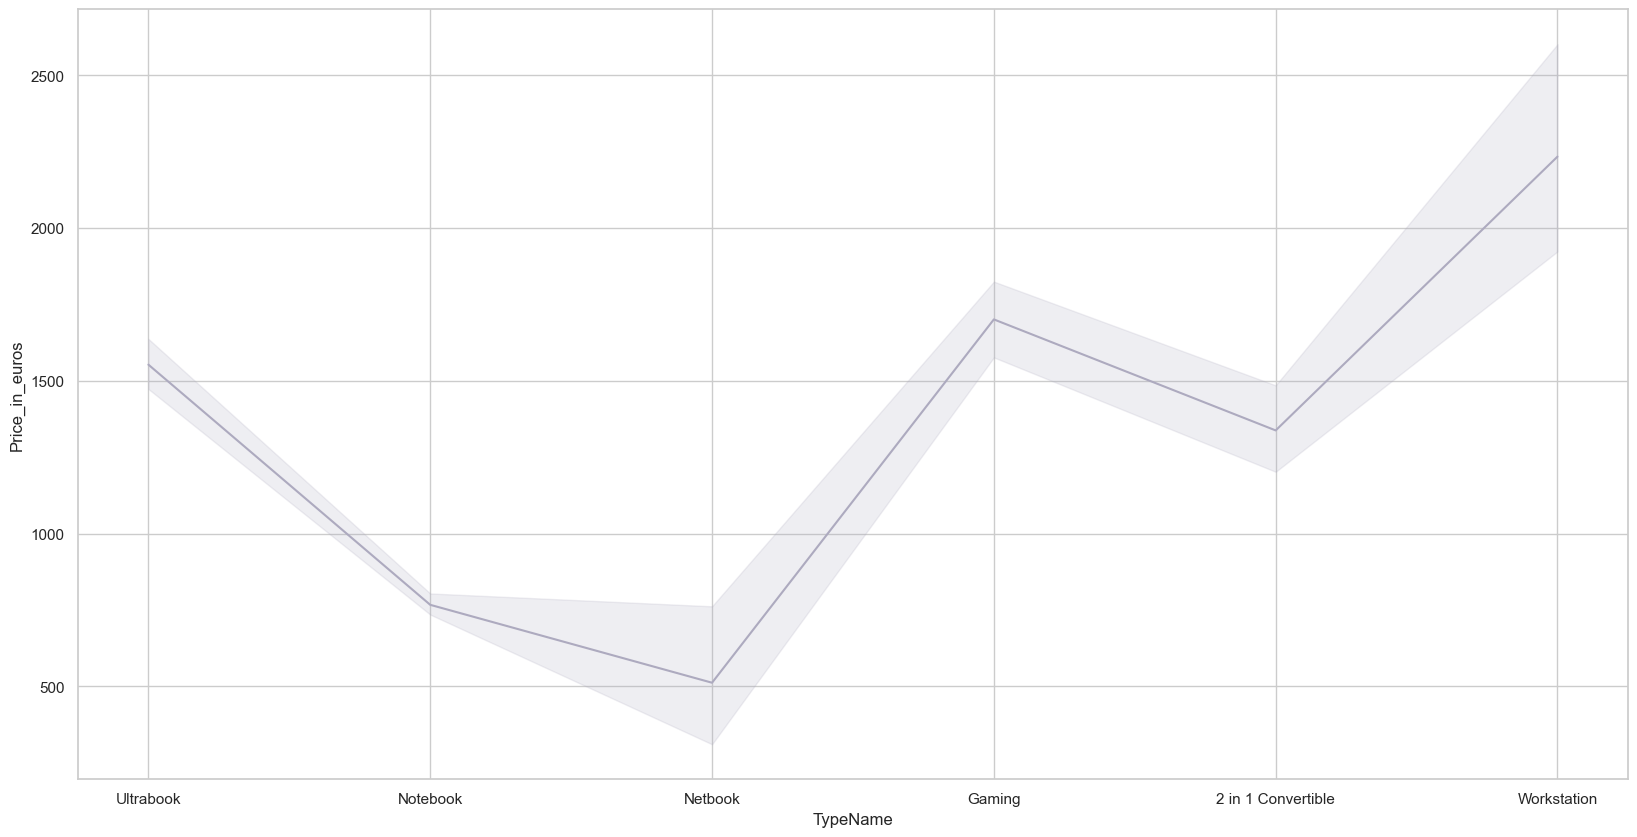

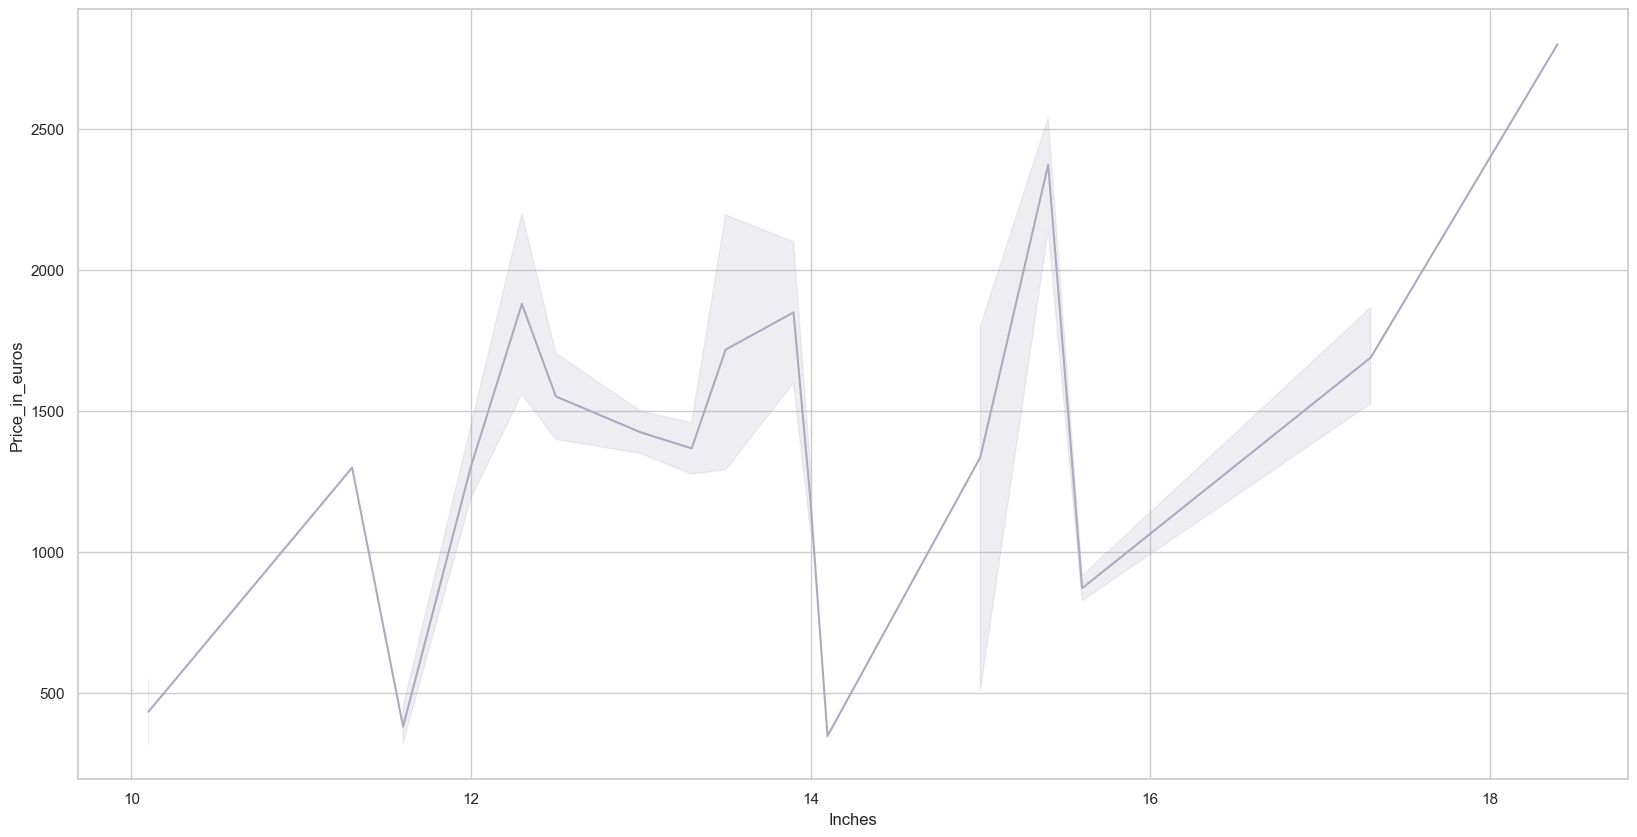

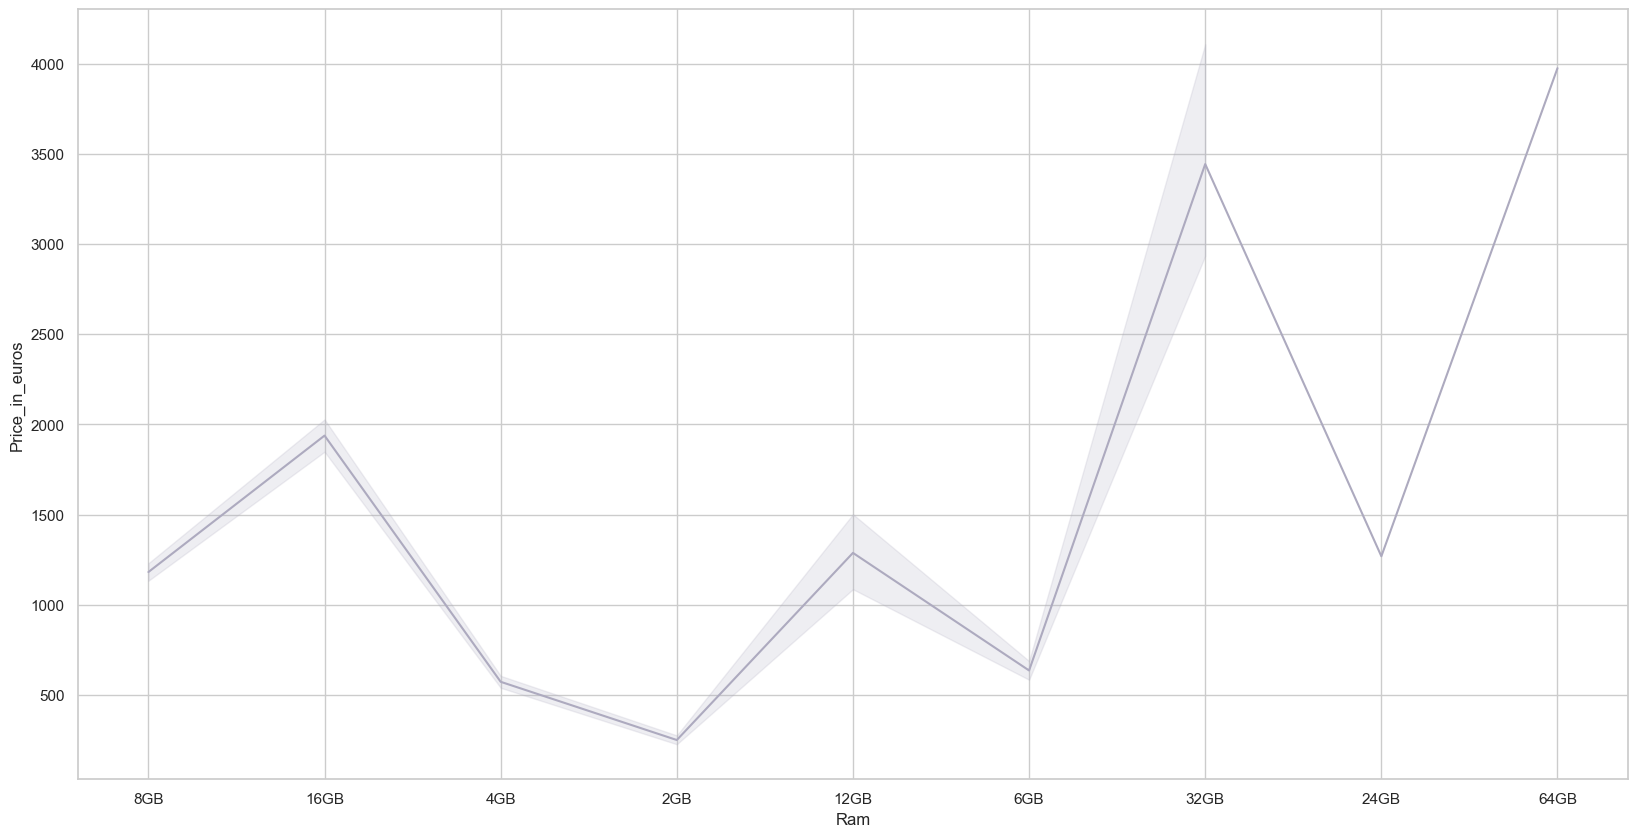

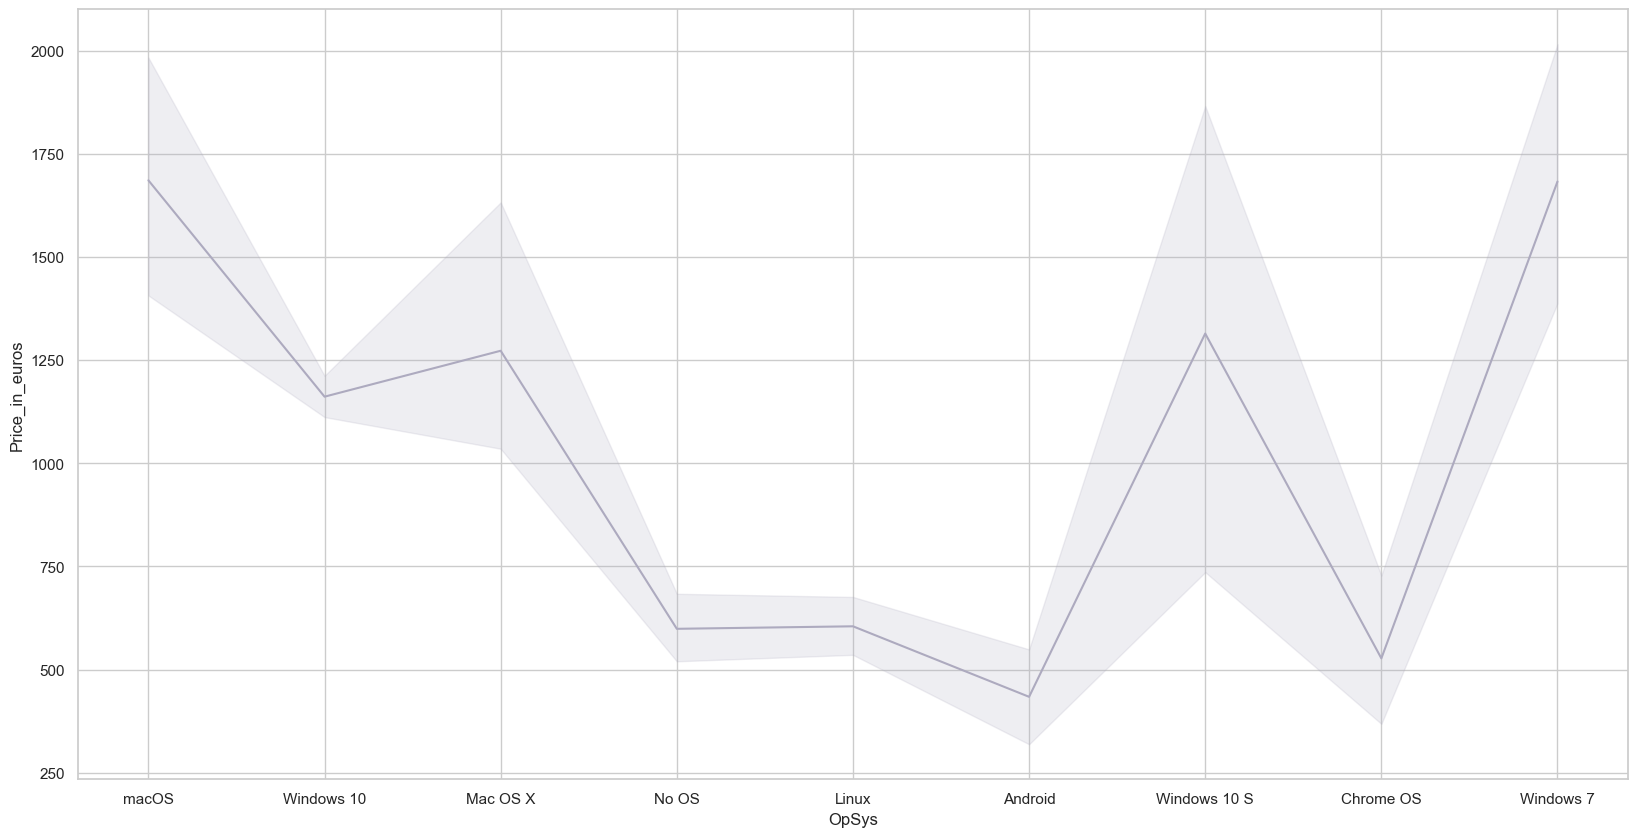

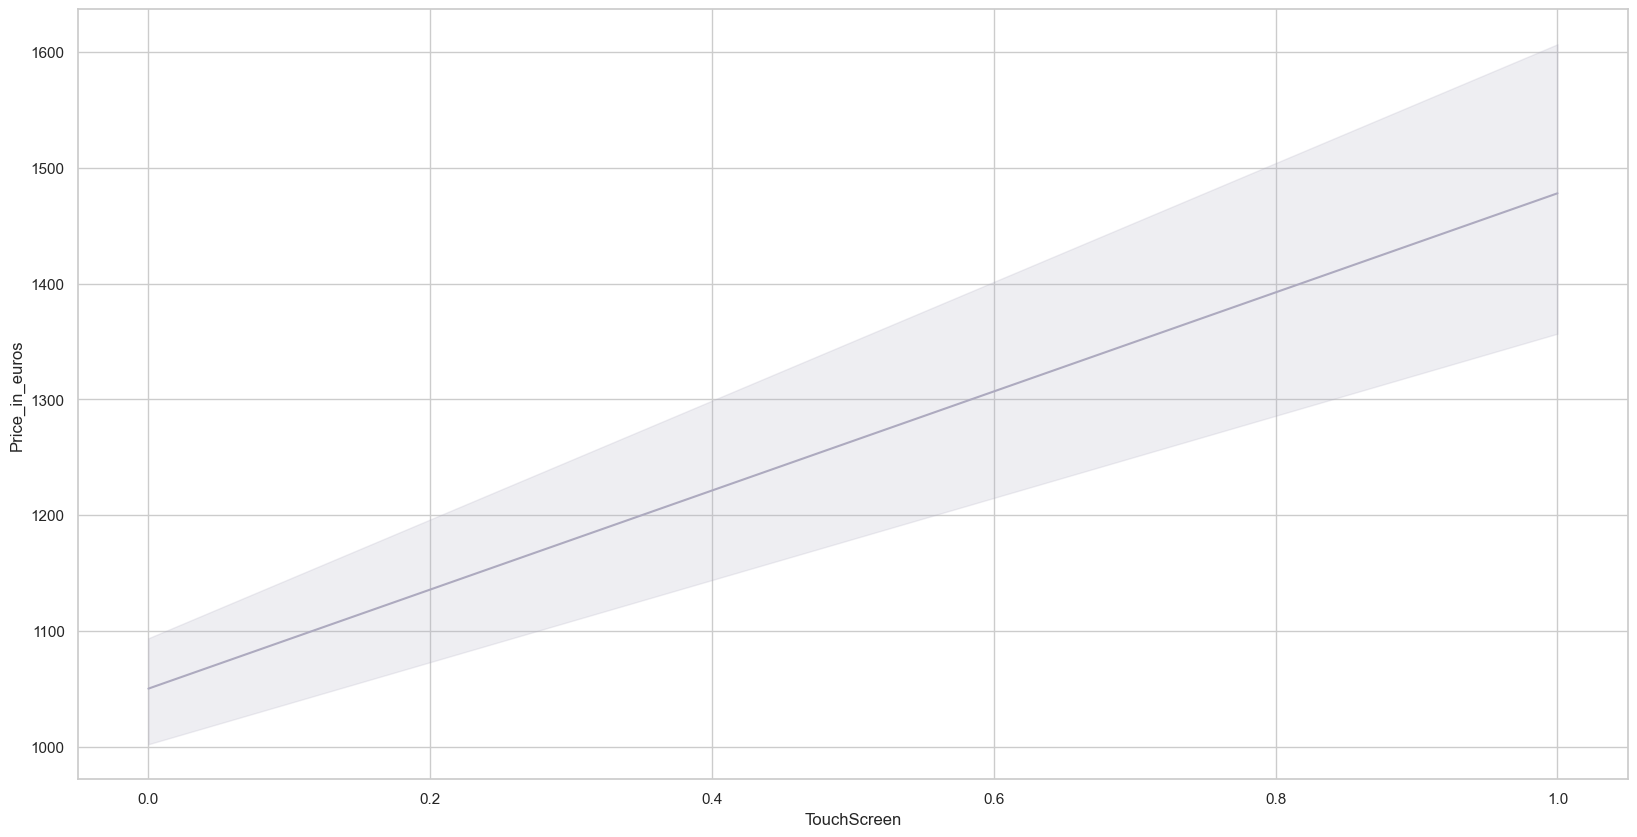

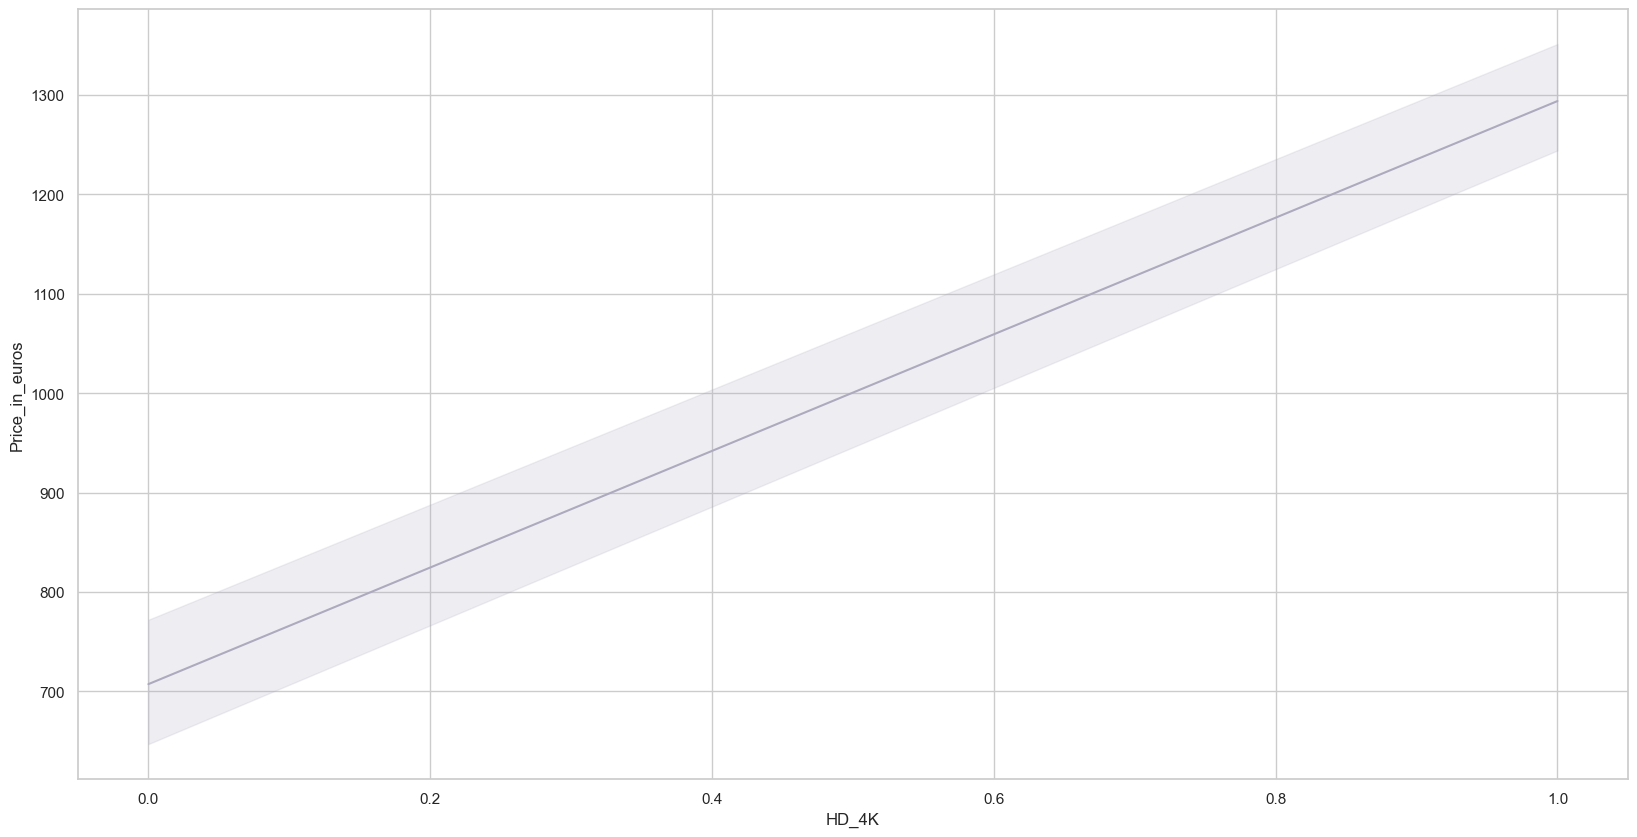

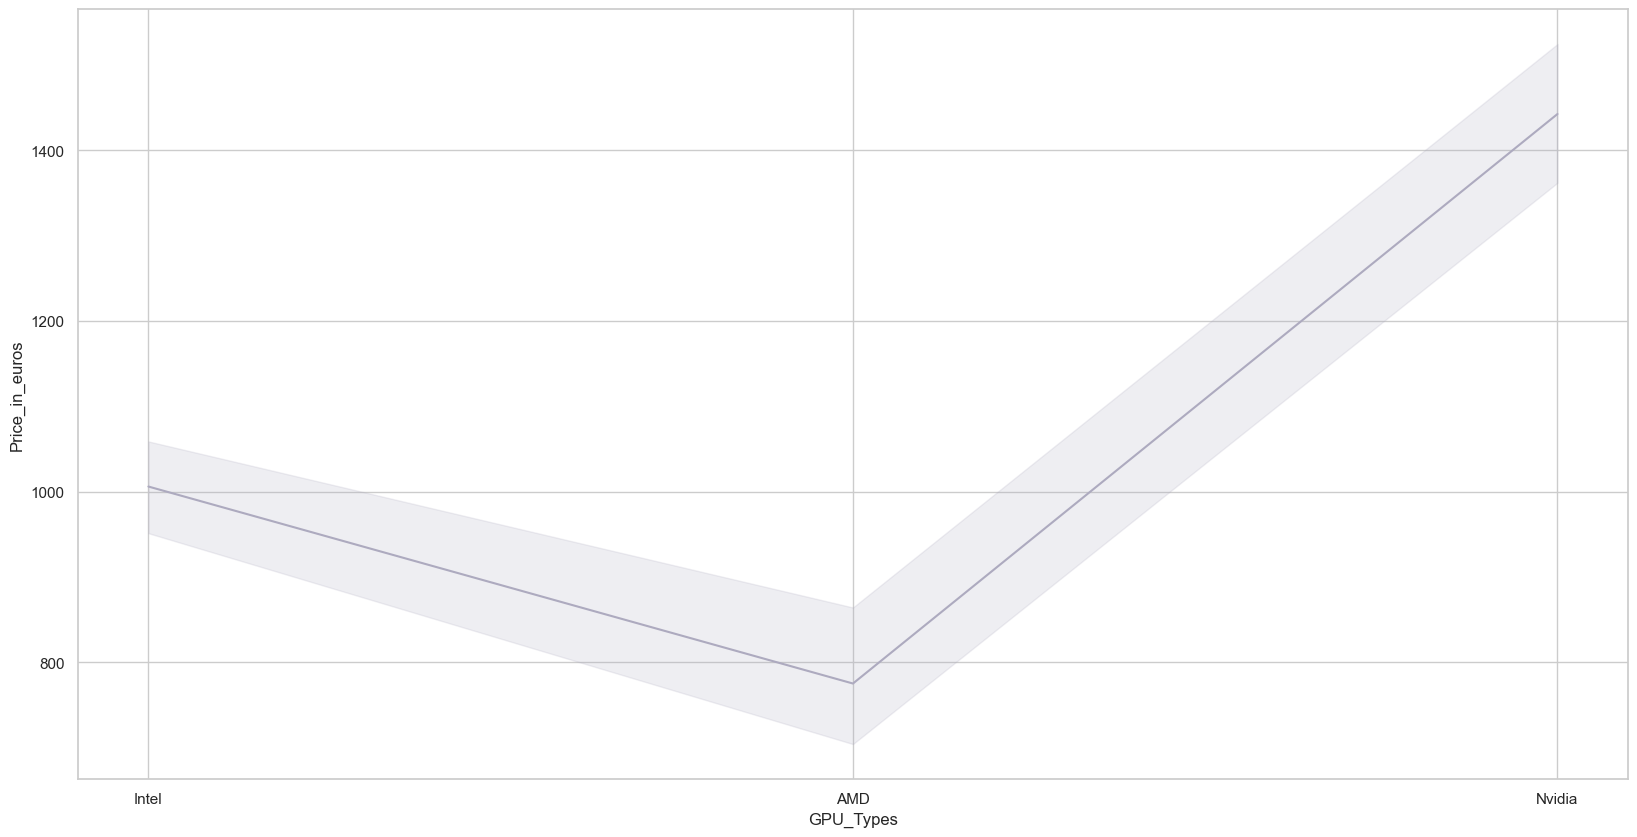

In [22]:
sns.set ( style = "whitegrid" )
for i in df_train.drop ( columns = [ 'Price_in_euros' , 'Weight' , 'Gpu','CPU_Types' , 'Memory_Types', 'Product', 'ScreenResolution','Cpu','Memory','CPU_Frequency' ]  ) :    
    plt.figure ( figsize = ( 20 , 10 ) )    
    sns.lineplot ( x = df_train [ i ].sort_values ( ) , y = df_train.Price_in_euros , color = '#ADAABF' , markers = '*'  )    
    plt.show()

### Distribucion de precios

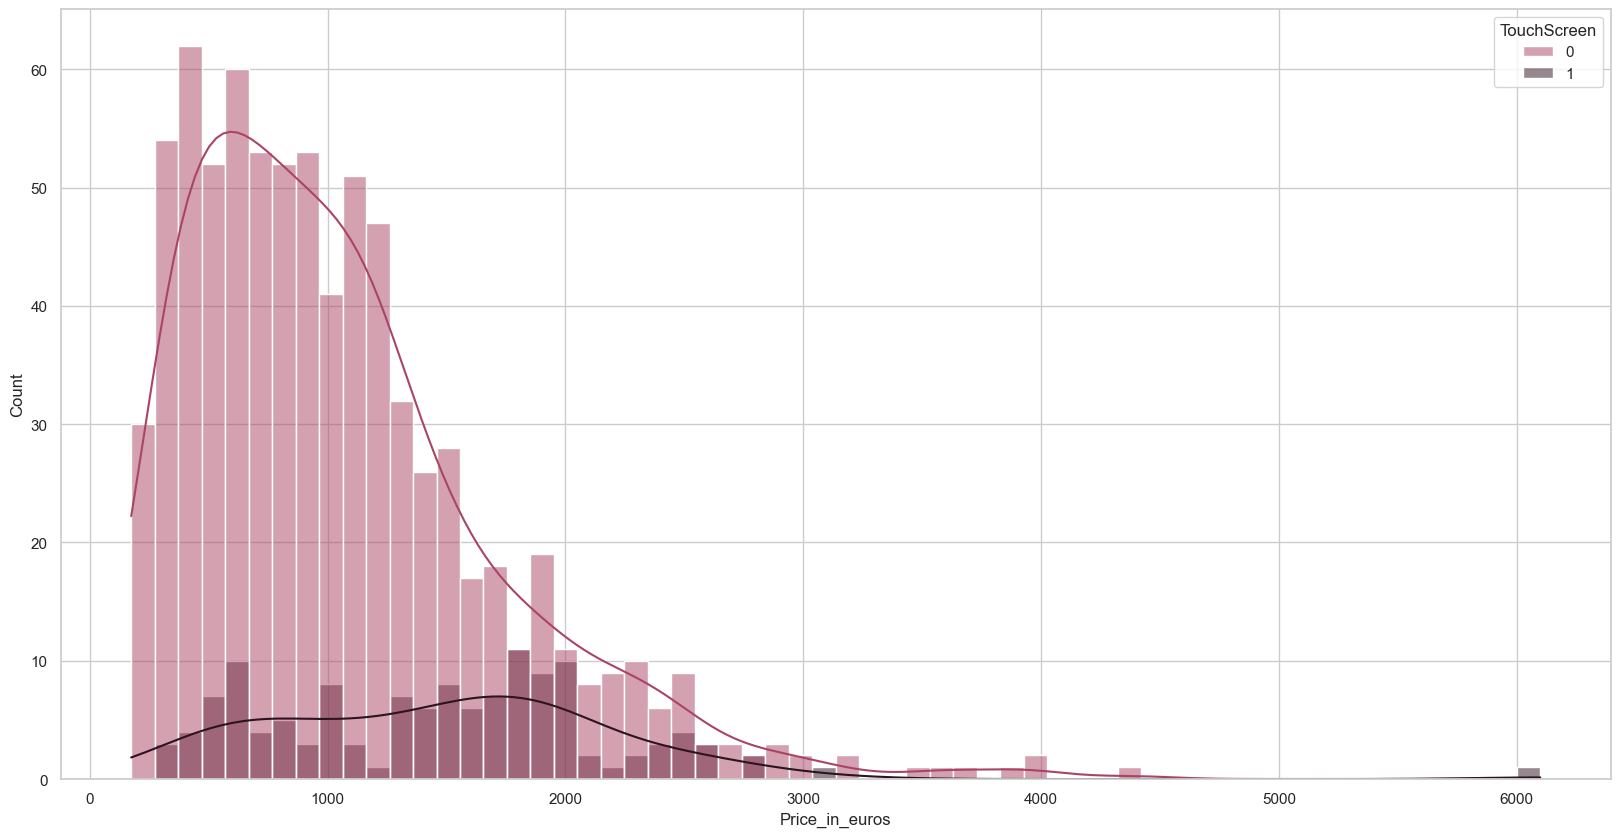

In [24]:
plt.figure ( figsize = ( 20 , 10 ) )
sns.histplot ( data = df_train , x = df_train.Price_in_euros , kde = True , hue = 'TouchScreen' , palette = [ '#AA4465', '#2C1320' ] , bins = 60 );

### Distribucion de RAM

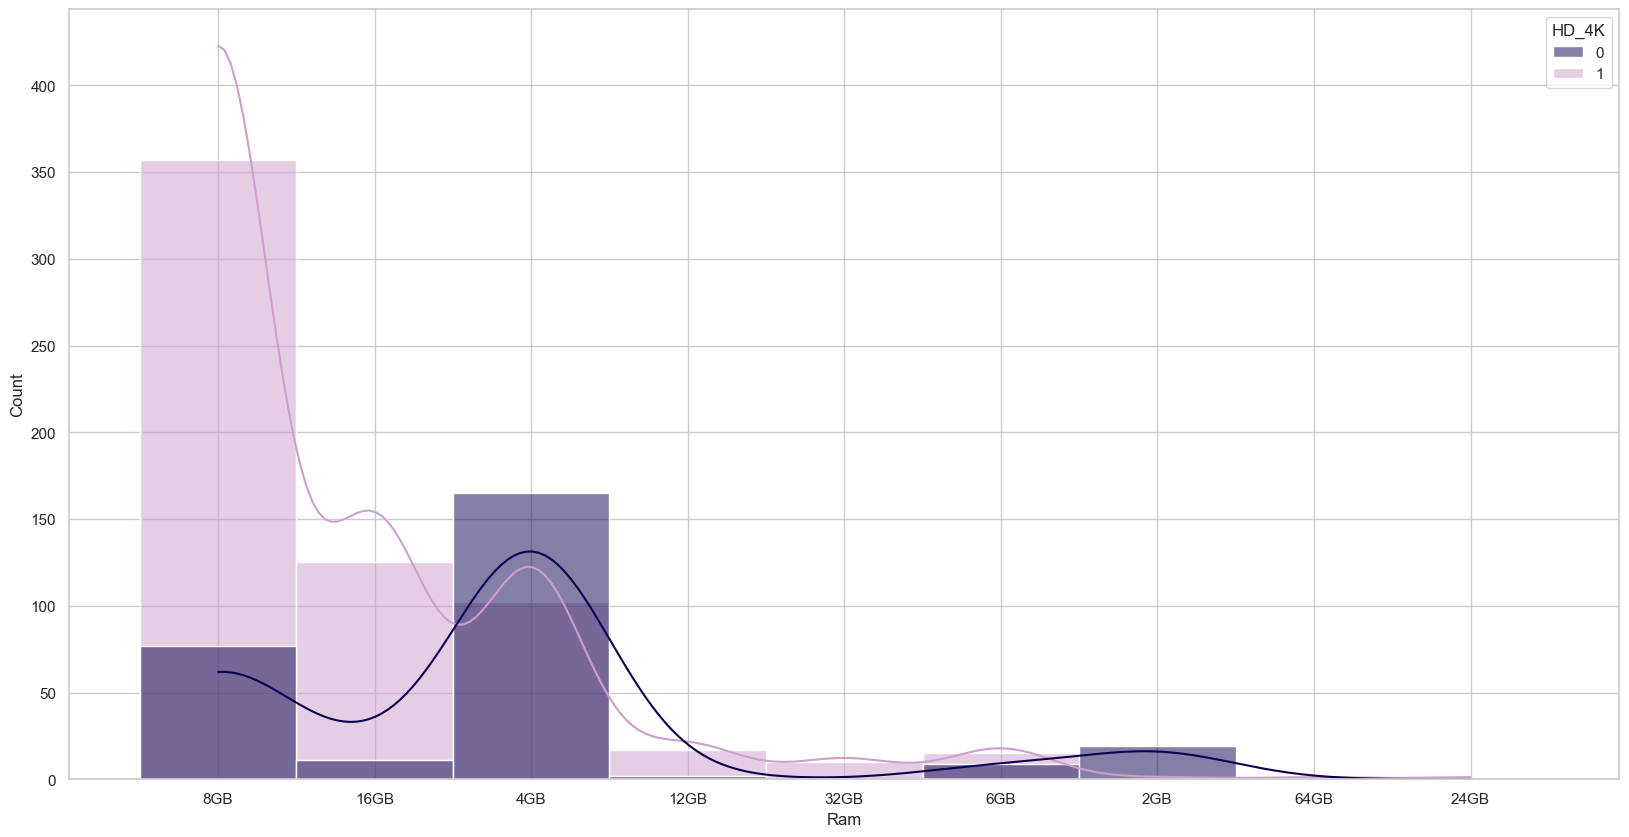

In [26]:
plt.figure ( figsize = ( 20 , 10 ) )
sns.histplot ( data = df_train , x = df_train.Ram , kde = True , hue =  'HD_4K' , palette = [ '#0A014F', '#CD9FCC' ] );

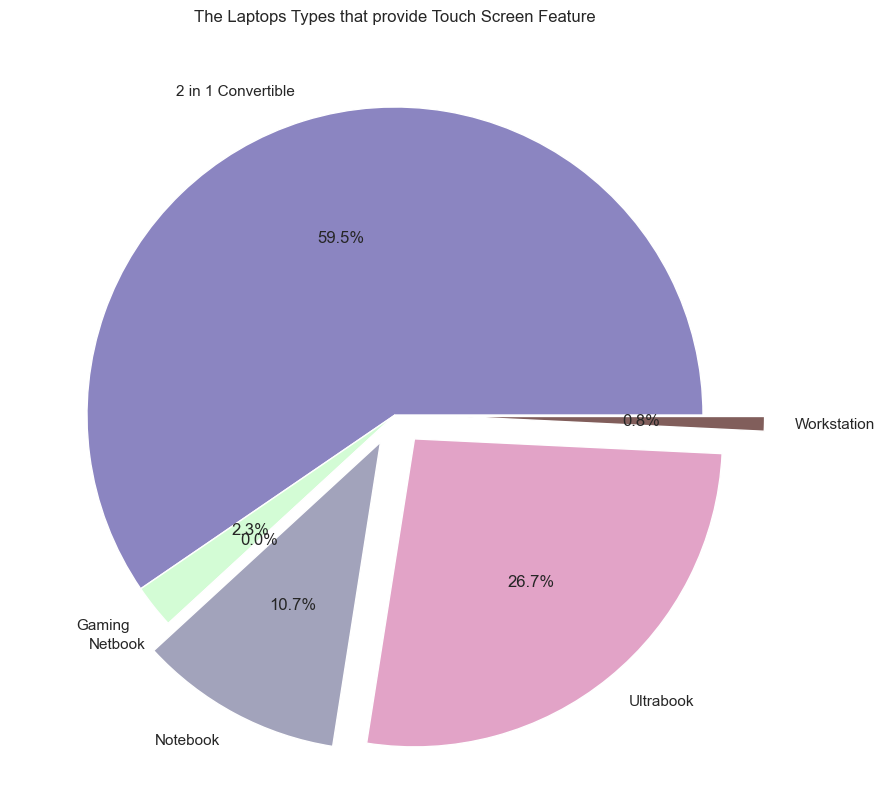

In [27]:

Data = df_train.groupby ( by = ['TypeName']  ).sum ( ).reset_index ( ).loc [ : , ['TouchScreen', 'TypeName'] ]
Colors = [ '#8B85C1' , '#D3FCD5' , '#A8DCD9' , '#A2A3BB' , '#E2A3C7'  , '#815E5B' ,  '#7A6F9B' ]
plt.figure ( figsize = ( 20 , 10 ) )
plt.pie ( x = Data.TouchScreen , autopct = '%1.1f%%', colors = Colors , explode = [ 0 , 0 , 0 , 0.1 , 0.1 , 0.2 ] , labels = list(Data.TypeName.unique ( ))) ;
plt.title ( "The Laptops Types that provide Touch Screen Feature" );

### Outliers

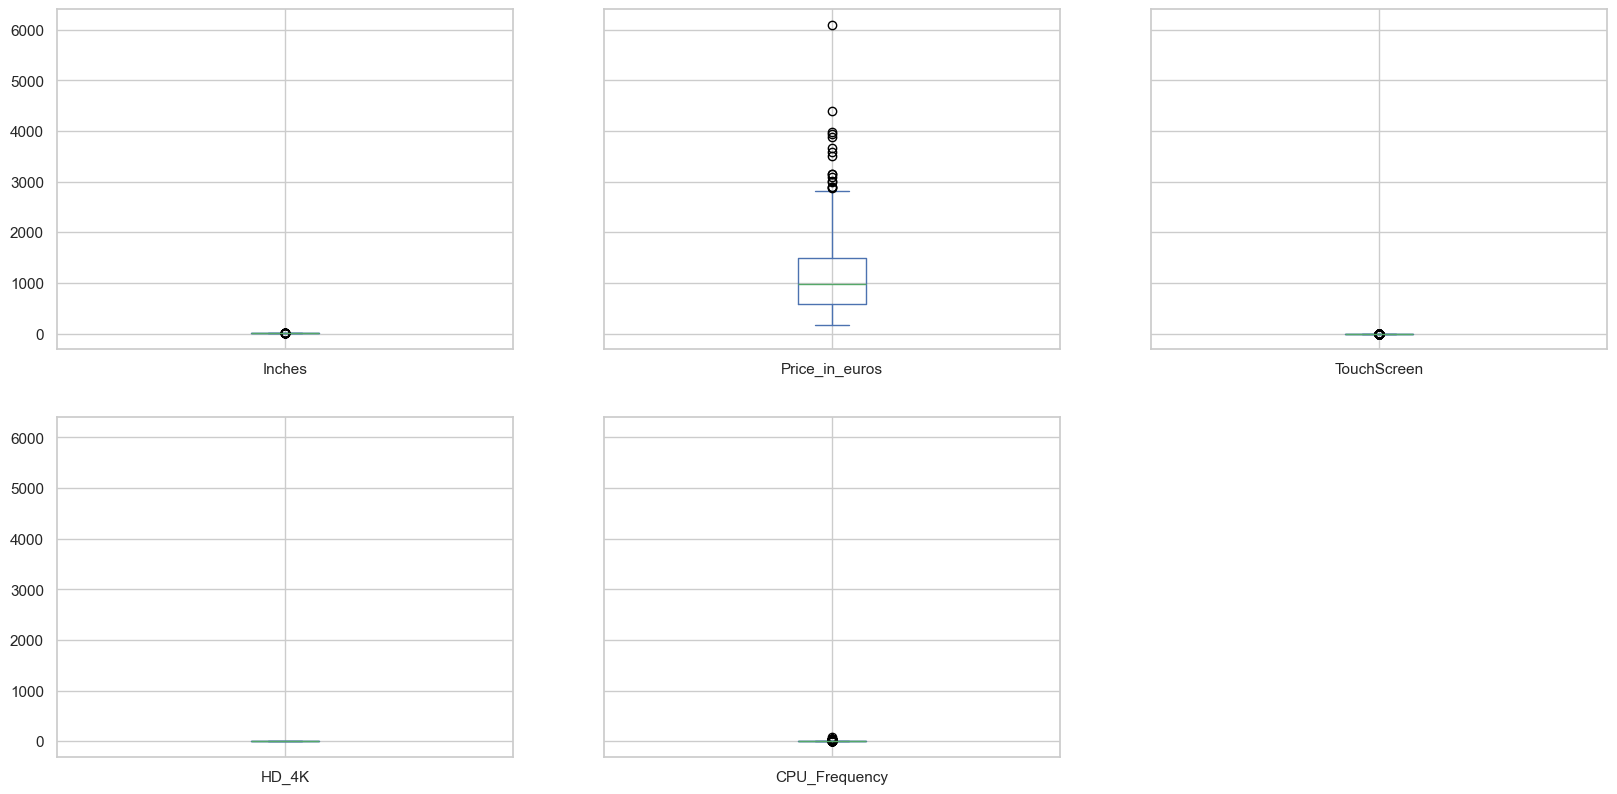

In [29]:
df_train.select_dtypes ( np.number ).plot ( kind = 'box' , subplots = True , layout = ( 3 , 3 ) , figsize = ( 20 , 15 ) , sharex = True , sharey = True );


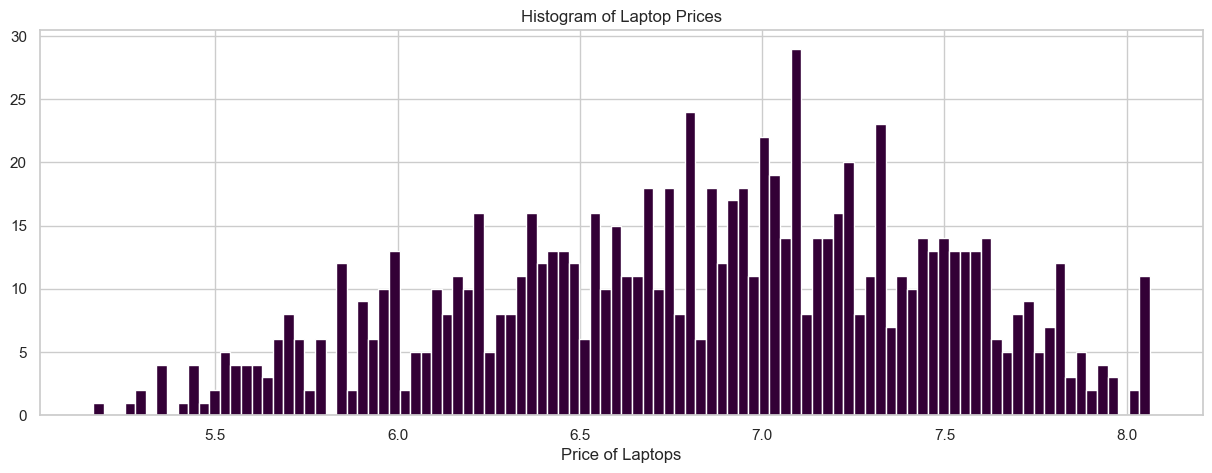

In [30]:
#Tratamiento de outliers

Mean = df_train.Price_in_euros.mean ( )
Std_Dev = df_train.Price_in_euros.std ( )
Threshold = 3
Lower_Limit = Mean - Threshold * Std_Dev
Upper_Limit = Mean + Threshold * Std_Dev

df_train [ 'Price_in_euros' ] = df_train [ 'Price_in_euros' ].apply ( lambda x : Lower_Limit if x < Lower_Limit else ( Upper_Limit if x > Upper_Limit else x ) )
df_train['Price_in_euros']  = pd.DataFrame ( np.log1p ( df_train [ [ 'Price_in_euros' ] ] ) )


plt.figure ( figsize = ( 15 , 5 ) )

df_train.Price_in_euros.hist ( bins = 100 , color = '#330036' );

plt.xlabel ( "Price of Laptops" )

plt.title ( "Histogram of Laptop Prices" );


## Limpieza de datos
### Valores nulos

In [33]:
print ( 'Valores nulos en el dataset : \n' )
df_train.isnull ( ).sum ( ) [ df_train.isnull ( ).sum ( ) > 0 ]

Valores nulos en el dataset : 



Series([], dtype: int64)

In [38]:
df_test.isnull ( ).sum ( ) [ df_train.isnull ( ).sum ( ) > 0 ]

Series([], dtype: int64)

### Columnas categoricas

In [44]:
df_train.select_dtypes ( 'object' )

,Company,Product,TypeName,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,CPU_Types,Memory_Types,GPU_Types
755,HP,250 G6,Notebook,Full HD 1920x1080,Intel Core i3 6006U 2GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.86kg,Intel,SSD,Intel
618,Dell,Inspiron 7559,Gaming,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,16GB,1TB HDD,Nvidia GeForce GTX 960<U+039C>,Windows 10,2.59kg,Intel,HDD,Nvidia
909,HP,ProBook 450,Notebook,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,Nvidia GeForce 930MX,Windows 10,2.04kg,Intel,HDD,Nvidia
2,Apple,Macbook Air,Ultrabook,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,Intel,Flash Storage,Intel
286,Dell,Inspiron 3567,Notebook,Full HD 1920x1080,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,AMD Radeon R5 M430,Linux,2.25kg,Intel,HDD,AMD
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,Dell,Inspiron 5570,Notebook,Full HD 1920x1080,Intel Core i5 8250U 1.6GHz,8GB,256GB SSD,AMD Radeon 530,Windows 10,2.2kg,Intel,SSD,AMD
1160,HP,Spectre Pro,2 in 1 Convertible,Full HD / Touchscreen 1920x1080,Intel Core i5 6300U 2.4GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.48kg,Intel,SSD,Intel
78,Lenovo,IdeaPad 320-15IKBN,Notebook,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,2TB HDD,Intel HD Graphics 620,No OS,2.2kg,Intel,HDD,Intel
23,HP,255 G6,Notebook,1366x768,AMD E-Series E2-9000e 1.5GHz,4GB,500GB HDD,AMD Radeon R2,No OS,1.86kg,AMD,HDD,AMD


In [45]:
Columnas_categoricas = df_train.select_dtypes ( 'object' ).columns.to_list ( )
Columnas_categoricas = df_test.select_dtypes ( 'object' ).columns.to_list ( )

Columnas_categoricas

['Company',
 'Product',
 'TypeName',
 'ScreenResolution',
 'Cpu',
 'Ram',
 'Memory',
 'Gpu',
 'OpSys',
 'Weight',
 'CPU_Types',
 'Memory_Types',
 'GPU_Types']

In [46]:
for i in df_train.loc [ : , Columnas_categoricas ] :    
    print ( "\n--------------------------------------------------------------------------\n" , "Column => " , i )    
    display ( df_train [ i ].value_counts ( ) )


--------------------------------------------------------------------------
 Column =>  Company


Company
Lenovo       202
Dell         197
HP           194
Asus         121
Acer          74
MSI           37
Toshiba       34
Apple         17
Razer          6
Mediacom       6
Microsoft      5
Samsung        5
Xiaomi         3
Vero           2
Huawei         2
Google         2
Chuwi          2
Fujitsu        2
LG             1
Name: count, dtype: int64


--------------------------------------------------------------------------
 Column =>  Product


Product
XPS 13                                        23
Inspiron 3567                                 22
Legion Y520-15IKBN                            15
Vostro 3568                                   14
250 G6                                        13
                                              ..
15-AY023na (N3710/8GB/2TB/W10)                 1
R558UA-DM966T (i5-7200U/8GB/128GB/FHD/W10)     1
Precision 3510                                 1
Pavilion X360                                  1
GL62M 7RD                                      1
Name: count, Length: 480, dtype: int64


--------------------------------------------------------------------------
 Column =>  TypeName


TypeName
Notebook              509
Gaming                143
Ultrabook             141
2 in 1 Convertible     80
Workstation            20
Netbook                19
Name: count, dtype: int64


--------------------------------------------------------------------------
 Column =>  ScreenResolution


ScreenResolution
Full HD 1920x1080                                349
1366x768                                         211
IPS Panel Full HD 1920x1080                      163
IPS Panel Full HD / Touchscreen 1920x1080         32
Full HD / Touchscreen 1920x1080                   30
1600x900                                          14
Quad HD+ / Touchscreen 3200x1800                  11
Touchscreen 1366x768                              11
IPS Panel 4K Ultra HD / Touchscreen 3840x2160     10
4K Ultra HD / Touchscreen 3840x2160                7
IPS Panel Quad HD+ / Touchscreen 3200x1800         6
Touchscreen 2560x1440                              6
IPS Panel 4K Ultra HD 3840x2160                    5
Touchscreen 2256x1504                              5
IPS Panel Retina Display 2560x1600                 5
1440x900                                           4
IPS Panel 1366x768                                 4
IPS Panel Retina Display 2304x1440                 4
IPS Panel Touchscreen 2560x14


--------------------------------------------------------------------------
 Column =>  Cpu


Cpu
Intel Core i5 7200U 2.5GHz              124
Intel Core i7 7700HQ 2.8GHz             105
Intel Core i7 7500U 2.7GHz               97
Intel Core i5 8250U 1.6GHz               52
Intel Core i7 8550U 1.8GHz               47
                                       ... 
AMD E-Series 9000e 1.5GHz                 1
Intel Core i7 6560U 2.2GHz                1
Intel Core i5 6440HQ 2.6GHz               1
AMD E-Series E2-6110 1.5GHz               1
Intel Pentium Dual Core N4200 1.1GHz      1
Name: count, Length: 107, dtype: int64


--------------------------------------------------------------------------
 Column =>  Ram


Ram
8GB     434
4GB     267
16GB    136
6GB      24
2GB      20
12GB     19
32GB     10
64GB      1
24GB      1
Name: count, dtype: int64


--------------------------------------------------------------------------
 Column =>  Memory


Memory
256GB SSD                        282
1TB HDD                          152
500GB HDD                         92
512GB SSD                         83
128GB SSD +  1TB HDD              67
128GB SSD                         54
256GB SSD +  1TB HDD              52
32GB Flash Storage                33
1TB SSD                           12
64GB Flash Storage                11
512GB SSD +  1TB HDD               8
2TB HDD                            8
256GB Flash Storage                7
16GB Flash Storage                 6
256GB SSD +  2TB HDD               6
32GB SSD                           5
1.0TB Hybrid                       5
128GB Flash Storage                4
180GB SSD                          3
16GB SSD                           3
512GB SSD +  2TB HDD               2
1TB SSD +  1TB HDD                 2
1TB HDD +  1TB HDD                 1
512GB Flash Storage                1
1.0TB HDD                          1
256GB SSD +  500GB HDD             1
8GB SSD                        


--------------------------------------------------------------------------
 Column =>  Gpu


Gpu
Intel HD Graphics 620       185
Intel HD Graphics 520       125
Intel UHD Graphics 620       52
Nvidia GeForce GTX 1050      48
Nvidia GeForce 940MX         31
                           ... 
AMD Radeon R7 M365X           1
Nvidia GeForce GTX 980        1
Nvidia GeForce GTX 960        1
AMD Radeon R5 430             1
Nvidia GeForce GTX 1070M      1
Name: count, Length: 93, dtype: int64


--------------------------------------------------------------------------
 Column =>  OpSys


OpSys
Windows 10      741
Linux            48
No OS            44
Windows 7        29
Chrome OS        24
macOS            11
Windows 10 S      7
Mac OS X          6
Android           2
Name: count, dtype: int64


--------------------------------------------------------------------------
 Column =>  Weight


Weight
2.2kg     91
2.1kg     40
2.4kg     31
2.5kg     29
2.3kg     27
          ..
3.31kg     1
0.97kg     1
2.34kg     1
1.11kg     1
4.33kg     1
Name: count, Length: 165, dtype: int64


--------------------------------------------------------------------------
 Column =>  CPU_Types


CPU_Types
Intel    870
AMD       42
Name: count, dtype: int64


--------------------------------------------------------------------------
 Column =>  Memory_Types


Memory_Types
SSD              454
HDD              395
Flash Storage     63
Name: count, dtype: int64


--------------------------------------------------------------------------
 Column =>  GPU_Types


GPU_Types
Intel     509
Nvidia    284
AMD       119
Name: count, dtype: int64

### Matriz de correlacion

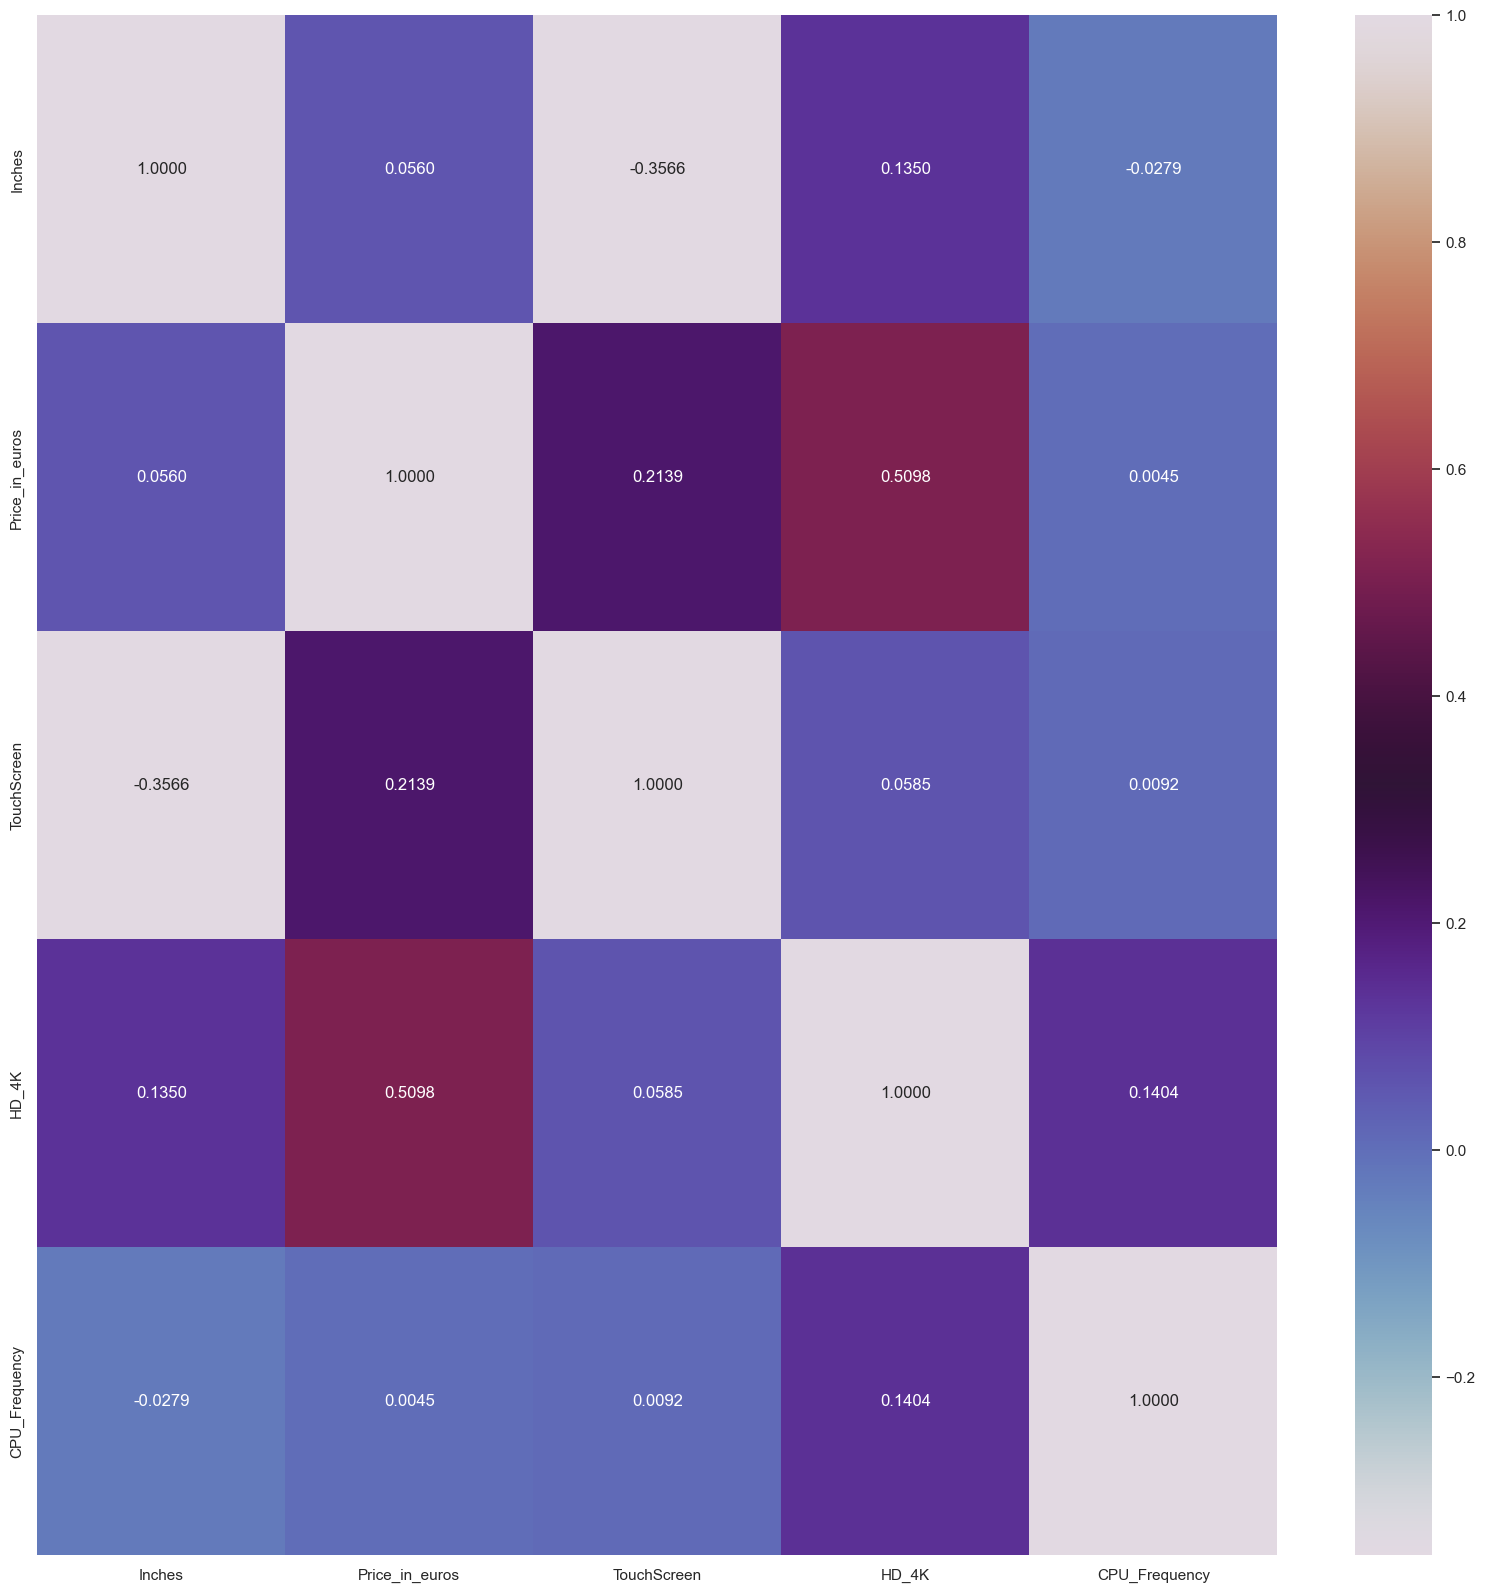

In [48]:
# Select only numeric columns
df_numeric = df_train.select_dtypes(include=['int64', 'float64'])

# Calculate the correlation matrix
corr_matrix = df_numeric.corr()

# Plot the heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(data=corr_matrix, cmap='twilight', annot=True, fmt='0.4f')
plt.show()

In [49]:
df_numeric.corr ( ) [ (df_numeric.corr ( ) > 0.2) | ( df_numeric.corr ( ) < -0.2 )].fillna ( '-' )

,Inches,Price_in_euros,TouchScreen,HD_4K,CPU_Frequency
Inches,1.0,-,-0.356602,-,-
Price_in_euros,-,1.0,0.213923,0.509847,-
TouchScreen,-0.356602,0.213923,1.0,-,-
HD_4K,-,0.509847,-,1.0,-
CPU_Frequency,-,-,-,-,1.0


## Data Preprocessing

In [51]:
Columnas = list(df_train.select_dtypes ( 'object' ).columns)
Columnas = list(df_test.select_dtypes ( 'object' ).columns)

In [52]:
X = df_train.drop([ 'Price_in_euros' , 'Inches' , 'Weight'], axis=1)
y = df_train['Price_in_euros'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)


## Modelado

### Regresion lineal

In [57]:
Columnas = list(X_train.select_dtypes ( 'object' ).columns)

Step1 = ColumnTransformer ( transformers = [ ('col_tnf' , OneHotEncoder ( sparse_output=False , drop = 'first',handle_unknown='ignore' ) , Columnas ) ] , remainder = 'passthrough') 

Step2 = LinearRegression ( )

Pipeline_LR = Pipeline ( [ ( 'step1' , Step1) , ( 'step2' , Step2 ) ] )

Pipeline_LR.fit ( X_train , y_train )


Pipeline(steps=[('step1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('col_tnf',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Company', 'Product',
                                                   'TypeName',
                                                   'ScreenResolution', 'Cpu',
                                                   'Ram', 'Memory', 'Gpu',
                                                   'OpSys', 'CPU_Types',
                                                   'Memory_Types',
                                                   'GPU_Types'])])),
                ('step2', LinearRegression())])

In [59]:
Y_LR = Pipeline_LR.predict ( X_test )
R2_LR = r2_score ( y_test , Y_LR ) * 100
N = X_train.shape[0] 
P = X_train.shape[1]

print ( "The R2 value or Coefficient of determination is : " , R2_LR )

Adjusted_R2_LR = 1 - ( ( 1 - R2_LR ) * ( N - 1 ) / ( N - 1 - P ) )
MSE_LR = mean_squared_error ( y_test , Y_LR )
RMSE_LR = np.sqrt ( MSE_LR )
MAPE_LR = mean_absolute_percentage_error ( y_test , Y_LR ) * 100
MAE_LR = mean_absolute_error ( y_test , Y_LR )

print ( "\nThe Adjusted R2 value is : " , Adjusted_R2_LR )

The R2 value or Coefficient of determination is :  78.56573748653169

The Adjusted R2 value is :  80.19755524571539


In [60]:
LR_PM = { 'Performance Metric' : [ 'R2' , 'Adjusted_R2' , 'MSE' , 'RMSE' , 'MAPE' , 'MAE' ] , 
                   'Values' : [ R2_LR , Adjusted_R2_LR , MSE_LR , RMSE_LR , MAPE_LR , MAE_LR ] }

LR_Performance_Metrics = pd.DataFrame ( LR_PM )

LR_Performance_Metrics

,Performance Metric,Values
0,R2,78.565737
1,Adjusted_R2,80.197555
2,MSE,0.096532
3,RMSE,0.310696
4,MAPE,3.180711
5,MAE,0.213335


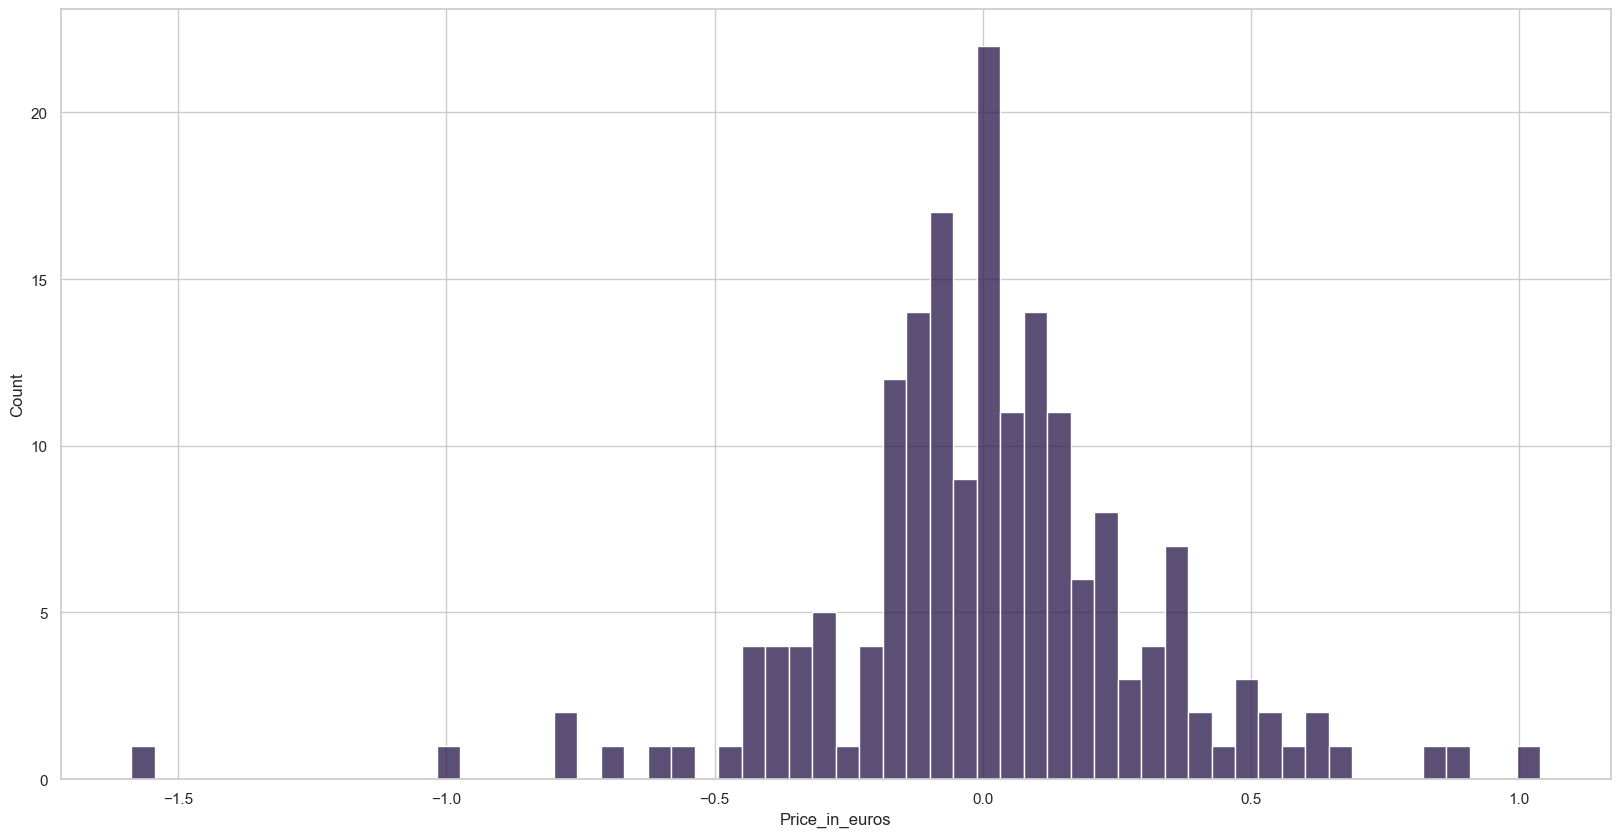

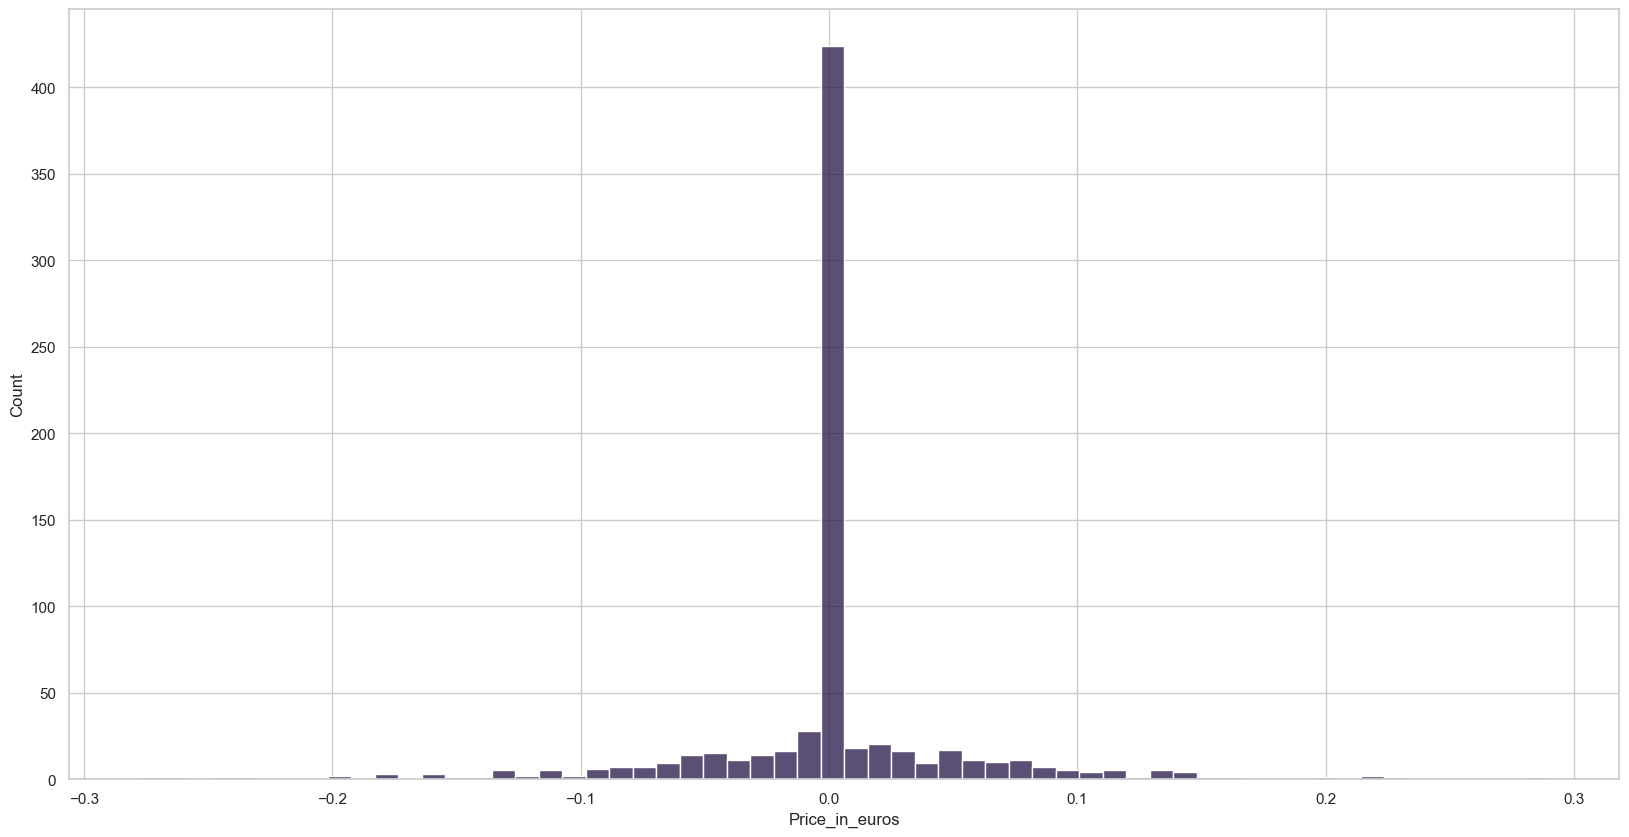

In [61]:
plt.figure ( figsize = ( 20 , 10 ) )

sns.histplot ( ( Y_LR - y_test ) , bins = 60 , color = '#261447' )

Y_Train_LR = Pipeline_LR.predict ( X_train )

plt.figure ( figsize = ( 20 , 10 ) )

sns.histplot ( ( Y_Train_LR - y_train ) , bins = 60 , color = '#261447' );


### Ridge Regression

In [63]:
Columnas = list(X_train.select_dtypes ( 'object' ).columns)
Step1 = ColumnTransformer(
    transformers=[
        ('col_tnf', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'), Columnas)
    ],
    remainder='passthrough'
)
R = Ridge ( )

Parameters = { 'alpha' : [ 1.0 , 2.0 , 3.0 ] , 'max_iter' : [ 100 , 200 , 500 ] }

Step2 = GridSearchCV ( estimator = R , param_grid = Parameters , cv = 5 )

Pipeline_R = Pipeline ( [ ( 'step1' , Step1) , ( 'step2' , Step2 ) ] )

Pipeline_R.fit ( X_train , y_train )

Parameters = Step2.best_params_

Step3 = Ridge ( **Parameters )

Pipeline_R = Pipeline ( [ ( 'step1' , Step1) , ( 'step3' , Step3 ) ] )

Pipeline_R.fit ( X_train , y_train )

Pipeline(steps=[('step1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('col_tnf',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Company', 'Product',
                                                   'TypeName',
                                                   'ScreenResolution', 'Cpu',
                                                   'Ram', 'Memory', 'Gpu',
                                                   'OpSys', 'CPU_Types',
                                                   'Memory_Types',
                                                   'GPU_Types'])])),
                ('step3', Ridge(max_iter=100))])

In [64]:
Y_R = Pipeline_R.predict ( X_test )

R2_R = r2_score ( y_test , Y_R ) * 100

N = X_train.shape[0] 

P = X_train.shape[1]

print ( "The R2 value or Coefficient of determination is : " , R2_R )

Adjusted_R2_R = 1 - ( ( 1 - R2_R ) * ( N - 1 ) / ( N - 1 - P ) )

MSE_R = mean_squared_error ( y_test , Y_R )

RMSE_R = np.sqrt ( MSE_R )

MAPE_R = mean_absolute_percentage_error ( y_test , Y_R ) * 100

MAE_R = mean_absolute_error ( y_test , Y_R )

print ( "\nThe Adjusted R2 value is : " , Adjusted_R2_R )

The R2 value or Coefficient of determination is :  87.18541239102397

The Adjusted R2 value is :  88.99856973445364


In [65]:

R_PM = { 'Performance Metric' : [ 'R2' , 'Adjusted_R2' , 'MSE' , 'RMSE' , 'MAPE' , 'MAE' ] , 
        
           'Values' : [ R2_R , Adjusted_R2_R , MSE_R , RMSE_R , MAPE_R , MAE_R ] }

R_Performance_Metrics = pd.DataFrame ( R_PM )

R_Performance_Metrics

,Performance Metric,Values
0,R2,87.185412
1,Adjusted_R2,88.998570
2,MSE,0.057712
3,RMSE,0.240233
4,MAPE,2.657458
5,MAE,0.177834


### Gradient boosting

In [81]:
GB = GradientBoostingRegressor ( )

Parameters = { 'n_estimators' : [ 50 , 100 , 200 ] , 'learning_rate' : [ 0.1 , 0.01, 1 ] , 
              
              'loss' : [ 'squared_error', 'absolute_error', 'huber', 'quantile' ] }

Step2 = GridSearchCV ( estimator = GB , param_grid = Parameters , cv = 5 )

Pipeline_GB = Pipeline ( [ ( 'step1' , Step1) , ( 'step2' , Step2 ) ] )

Pipeline_GB.fit ( X_train , y_train )

Parameters = Step2.best_params_

Step3 = GradientBoostingRegressor ( **Parameters )

Pipeline_GB = Pipeline ( [ ( 'step1' , Step1) , ( 'step3' , Step3 ) ] )

Pipeline_GB.fit ( X_train , y_train )

Pipeline(steps=[('step1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('col_tnf',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Company', 'Product',
                                                   'TypeName',
                                                   'ScreenResolution', 'Cpu',
                                                   'Ram', 'Memory', 'Gpu',
                                                   'OpSys', 'CPU_Types',
                                                   'Memory_Types',
                                                   'GPU_Types'])])),
                ('step3', GradientBoostingRegressor(n_estimators=200))])

In [83]:
Y_GB = Pipeline_GB.predict ( X_test )

R2_GB = r2_score ( y_test , Y_GB ) * 100

print ( "The R2 value or Coefficient of determination is : " , R2_GB )

Adjusted_R2_GB = 1 - ( ( 1 - R2_GB ) * ( N - 1 ) / ( N - 1 - P ) )

MSE_GB = mean_squared_error ( y_test , Y_GB )

RMSE_GB = np.sqrt ( MSE_GB )

MAPE_GB = mean_absolute_percentage_error ( y_test , Y_GB ) * 100

MAE_GB = mean_absolute_error ( y_test , Y_GB )

print ( "\nThe Adjusted R2 value is : " , Adjusted_R2_GB )

The R2 value or Coefficient of determination is :  85.9578770996233

The Adjusted R2 value is :  87.74520971742744


### Random Forest Regression

In [ ]:
Columnas = list(X_train.select_dtypes ( 'object' ).columns)

Step1 = ColumnTransformer ( transformers = [ ('col_tnf' , OneHotEncoder ( sparse_output = False , drop = 'first' ) , Columnas ) ] , remainder = 'passthrough') 

RF = RandomForestRegressor ( )

Parameters = { 'n_estimators' : [ 100 , 200 , 1000 ] ,
              
              'max_depth' : [ 10 , 15 , 20 ] , 'criterion' : [ "squared_error", "absolute_error", "friedman_mse", "poisson" ] }

Step2 = GridSearchCV ( estimator = RF , param_grid = Parameters , cv = 5 )

Pipeline_RF = Pipeline ( [ ( 'step1' , Step1) , ( 'step2' , Step2 ) ] )

Pipeline_RF.fit ( X_train , y_train )

Parameters = Step2.best_params_

Step3 = RandomForestRegressor ( **Parameters )

Pipeline_RF = Pipeline ( [ ( 'step1' , Step1) , ( 'step3' , Step3 ) ] )

Pipeline_RF.fit ( X_train , y_train )

In [ ]:
Y_RF = Pipeline_RF.predict ( X_test )

R2_RF = r2_score ( y_test , Y_RF ) * 100

N = x_train.shape[0] 

P = x_train.shape[1]

print ( "The R2 value or Coefficient of determination is : " , R2_RF )

Adjusted_R2_RF = 1 - ( ( 1 - R2_RF ) * ( N - 1 ) / ( N - 1 - P ) )

MSE_RF = mean_squared_error ( y_test , Y_RF )

RMSE_RF = np.sqrt ( MSE_RF )

MAPE_RF = mean_absolute_percentage_error ( y_test , Y_RF ) * 100

MAE_RF = mean_absolute_error ( y_test , Y_RF )

print ( "\nThe Adjusted R2 value is : " , Adjusted_R2_RF )

In [ ]:
RF_PM = { 'Performance Metric' : [ 'R2' , 'Adjusted_R2' , 'MSE' , 'RMSE' , 'MAPE' , 'MAE' ] , 
        
           'Values' : [ R2_RF , Adjusted_R2_RF , MSE_RF , RMSE_RF , MAPE_RF , MAE_RF ] }

RF_Performance_Metrics = pd.DataFrame ( RF_PM )

RF_Performance_Metrics

### Adaboost Regressor

In [ ]:
Columnas = list(x_train.select_dtypes ( 'object' ).columns)

Step1 = ColumnTransformer ( transformers = [ ('col_tnf' , OneHotEncoder ( sparse_output = False , drop = 'first' ) , Columns ) ] , remainder = 'passthrough') 

AB = AdaBoostRegressor ( )

Parameters = { 'n_estimators' : [ 50 , 100 , 200 ] ,
              
              'learning_rate' : [ 0.1 , 0.01, 1 ] , 'estimator' : [ RF ] }

Step2 = GridSearchCV ( estimator = AB , param_grid = Parameters , cv = 5 )

Pipeline_AB = Pipeline ( [ ( 'step1' , Step1) , ( 'step2' , Step2 ) ] )

Pipeline_AB.fit ( x_train , y_train )

Parameters = Step2.best_params_

Step3 = AdaBoostRegressor ( **Parameters )

Pipeline_AB = Pipeline ( [ ( 'step1' , Step1) , ( 'step3' , Step3 ) ] )

Pipeline_AB.fit ( x_train , y_train )

In [ ]:
Y_AB = Pipeline_AB.predict ( X_test )

R2_AB = r2_score ( y_test , Y_AB ) * 100

N = X_train.shape[0] 

P = X_train.shape[1]

print ( "The R2 value or Coefficient of determination is : " , R2_AB )

Adjusted_R2_AB = 1 - ( ( 1 - R2_AB ) * ( N - 1 ) / ( N - 1 - P ) )

MSE_AB = mean_squared_error ( y_test , Y_AB )

RMSE_AB = np.sqrt ( MSE_AB )

MAPE_AB = mean_absolute_percentage_error ( y_test , Y_AB ) * 100

MAE_AB = mean_absolute_error ( y_test , Y_AB )

print ( "\nThe Adjusted R2 value is : " , Adjusted_R2_AB )

## Predigo test.csv

In [ ]:
predictions_submit1 = Pipeline_LR.predict(df_test)

In [ ]:
predictions_submit2 = Pipeline_R.predict(df_test)

In [ ]:
predictions_submit3 = Pipeline_GB.predict(df_test)

## Mete tus predicciones en un dataframe llamado submission.

In [ ]:
submission = pd.DataFrame({
    "laptop_ID": df_test.index,
    "Price_in_euros": predictions_submit3
})

In [ ]:
submission.head()
submission['Price_in_euros'] = submission['Price_in_euros'].apply(lambda x: round(x, 1))
submission

In [ ]:
sample = pd.read_csv("./data/sample_submission.csv")
sample

In [ ]:
def chequeador(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.
    
    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.
    
    Si no, LEE EL MENSAJE Y HAZLE CASO.
    
    Si aún no:
    - apaga tu ordenador, 
    - date una vuelta, 
    - enciendelo otra vez, 
    - abre este notebook y 
    - leelo todo de nuevo. 
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.laptop_ID.all() == sample.laptop_ID.all():
                print("You're ready to submit!")
                submission.to_csv("submission.csv", index = False) #muy importante el index = False
                urllib.request.urlretrieve("https://www.mihaileric.com/static/evaluation-meme-e0a350f278a36346e6d46b139b1d0da0-ed51e.jpg", "gfg.png")     
                img = Image.open("gfg.png")
                img.show()   
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("\nMensaje secreto del TA: No me puedo creer que después de todo este notebook hayas hecho algún cambio en las filas de `test.csv`. Lloro.")



In [ ]:
chequeador(submission)